# Análisis de viajes de taxi en NYC

Los datos que usaremos para este trabajo corresponden a los viajes de taxi realizados en 2016 en la ciudad de Nueva York.


## Importamos librerias

In [53]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns
import matplotlib.pyplot as plt
from haversine import haversine
import math
sns.set_style("whitegrid")
    
%matplotlib inline

Cargamos los datos

In [14]:
taxi_data = pd.read_csv('C:/Users/Rodrigo/Desktop/UP/2017-04/DataAnalisys/NYCTaxi/Data/train.csv')

In [52]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 16 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
PickUpDayNum          1458644 non-null int64
PickUpDayName         1458644 non-null object
DropOffDayNum         1458644 non-null int64
DropOffDayName        1458644 non-null object
Distance              1458644 non-null float64
dtypes: datetime64[ns](2), float64(5), int64(5), object(4)
memory usage: 178.1+ MB


In [15]:
taxi_data.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


## Hacemos un ETL, para tener los datos que usaremos.

1) Cambiamos el formato de pickup_datetime y de dropoff_datetime, a formato de fecha y hora.

2) Agregamos dia de la semana, numero de dia de la semana, tanto para la hora de recoger, como para la hora de dejar.

In [16]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format = "%Y/%m/%d %H:%M:%S")
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format = "%Y/%m/%d %H:%M:%S")

In [17]:
taxi_data['PickUpDayNum']=taxi_data['pickup_datetime'].dt.dayofweek
taxi_data['PickUpDayName']=taxi_data['pickup_datetime'].dt.weekday_name
taxi_data['DropOffDayNum']=taxi_data['dropoff_datetime'].dt.dayofweek
taxi_data['DropOffDayName']=taxi_data['dropoff_datetime'].dt.weekday_name
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,PickUpDayNum,PickUpDayName,DropOffDayNum,DropOffDayName
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,Monday,0,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,Sunday,6,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,Tuesday,1,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,Wednesday,2,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,Saturday,5,Saturday


## Continuamos con la segunda parte de nuestro ETL.

3) Hacemos el cálculo de la distancia entre el punto de origen y el punto de destino.

Hacemos un cálculo de la distancia haciendo una función haversine, que sirve para calcular distancias usando los datos de longitud y latitud.

In [49]:
def hav(row):
    lon1 = row['pickup_longitude']
    lat1 = row['pickup_latitude']
    lon2 = row['dropoff_longitude']
    lat2 = row['dropoff_latitude']
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    km = 6367 * c
    return km

taxi_data['Distance'] = taxi_data.apply(lambda row: hav(row), axis=1)

In [50]:
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,PickUpDayNum,PickUpDayName,DropOffDayNum,DropOffDayName,Distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,Monday,0,Monday,1.497580
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,Sunday,6,Sunday,1.804374
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,Tuesday,1,Tuesday,6.381090
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,Wednesday,2,Wednesday,1.484566
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,Saturday,5,Saturday,1.187842


## Terminamos el ETL 

4) Hacemos el cáluculo de la eficiencia del viaje, calculando el número de metros recorridos por segundo, a mayor número de metros por segundo, mayor eficiencia.

In [58]:
taxi_data['Eficiencia'] = taxi_data.Distance * 1000 / taxi_data.trip_duration

In [59]:
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,PickUpDayNum,PickUpDayName,DropOffDayNum,DropOffDayName,Distance,Eficiencia
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,Monday,0,Monday,1.497580,3.291384
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,Sunday,6,Sunday,1.804374,2.721529
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,Tuesday,1,Tuesday,6.381090,3.004279
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,Wednesday,2,Wednesday,1.484566,3.460526
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,Saturday,5,Saturday,1.187842,2.730672


Con esto terminamos nuestro ETL

## Iniciamos con el despliegue de la información de los viajes.

Text(0.5,1,'Número de viajes por día de la semana')

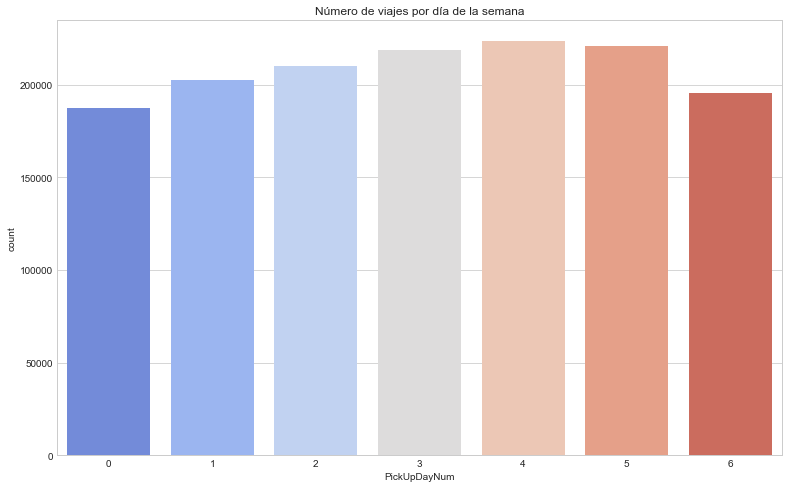

In [57]:
g = sns.countplot('PickUpDayNum', data=taxi_data, palette="coolwarm")
g.figure.set_size_inches(13,8)
g.set_title("Número de viajes por día de la semana")

Text(0.5,1,'Listado de eficiencia por día de la semana')

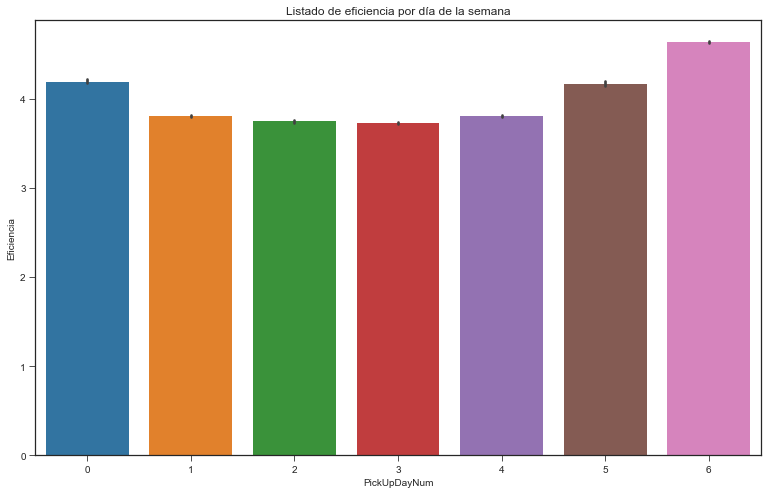

In [71]:
sns.set_style("ticks")
sns.despine()
sns.axes_style("darkgrid")
g = sns.barplot(x="PickUpDayNum", y="Eficiencia", data=taxi_data)
g.figure.set_size_inches(13,8)
g.set_title("Listado de eficiencia por día de la semana")

Si consideramos que los viajes que mas dinero dejan son los que mas distancia se recorre en el menor tiempo, de la gráfica anterior concluimos que los mejores viajes son los días viernes, sábado y domingo.

In [70]:
sns.set_style("ticks")
sns.despine()
sns.axes_style("darkgrid")
g = sns.barplot(x=taxi_data.pickup_datetime, y="Eficiencia", data=taxi_data)
g.figure.set_size_inches(13,8)
g.set_title("Listado de eficiencia por día de la semana")

AttributeError: 'Series' object has no attribute 'datetime'


Nuestro objetivo es:
    obtener los dias de la semana en que se piden mas taxis
    
    obtener las horas en las que mas se solicitan los taxis
    
    determinar la hora de mayor tráfico en la ciudad
    
    determinar la hora a la que se originan los viajes que salen de la isla de Manhattan
    

In [ ]:
g = sns.countplot('Eficiencia', data=taxi_data, palette="BuGn_d")
g.figure.set_size_inches(13,8)
g.set_title("Listado de eficiencia de los viajes")

In [63]:
taxi_data.head(50)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,PickUpDayNum,PickUpDayName,DropOffDayNum,DropOffDayName,Distance,Eficiencia
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,Monday,0,Monday,1.497580,3.291384
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,Sunday,6,Sunday,1.804374,2.721529
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,Tuesday,1,Tuesday,6.381090,3.004279
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,Wednesday,2,Wednesday,1.484566,3.460526
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,Saturday,5,Saturday,1.187842,2.730672
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,5,Saturday,5,Saturday,1.098252,2.479125
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341,4,Friday,4,Friday,1.325446,3.886938
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551,5,Saturday,5,Saturday,5.711393,3.682394
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255,4,Friday,4,Friday,1.309531,5.135414
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225,3,Thursday,3,Thursday,5.117946,4.177915


In [ ]:
from datetime import datetime
c = str(datetime.now())
print (c)

In [ ]:
a que hora hacer los viajes, donde esperar viajes


In [25]:
sns.set_style("ticks")
sns.despine()
sns.axes_style("darkgrid")
sinplot()


NameError: name 'sinplot' is not defined

In [ ]:
origen=(taxi_data['pickup_latitude'],taxi_data['pickup_longitude'])
destino=(taxi_data['dropoff_latitude'],taxi_data['dropoff_longitude'])
taxi_data['Distance']=taxi_data.apply(haversine(origen,destino))


In [12]:
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
